In [52]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks")
from multiclass_functions1_8 import * # all
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cuda


In [53]:
BATCH_SIZE = 32
LR = 1e-3
EPOCH = 5
criterion = nn.CrossEntropyLoss()
new_model_train = True
model_type = "CNN_deep"
dataset = "CIFAR10"
save_model_path = f"/content/drive/MyDrive/Colab Notebooks/results/{model_type}_{dataset}.pt"

In [54]:
transform = transforms.ToTensor()
train_DS = datasets.CIFAR10(root = '/content/drive/MyDrive/Colab Notebooks/data', train=True, download=True, transform=transform)
test_DS = datasets.CIFAR10(root = '/content/drive/MyDrive/Colab Notebooks/data', train=False, download=True, transform=transform)
train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [55]:
print(train_DS)
print(test_DS)
print(len(train_DS))
print(len(test_DS))

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content/drive/MyDrive/Colab Notebooks/data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /content/drive/MyDrive/Colab Notebooks/data
    Split: Test
    StandardTransform
Transform: ToTensor()
50000
10000


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
torch.Size([32, 3, 32, 32])
airplane


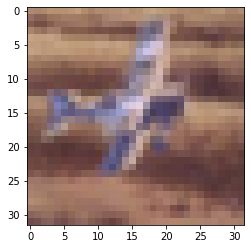

In [56]:
print(test_DS.classes)
print(test_DS.class_to_idx)
x_batch, y_batch = next(iter(test_DL))
print(x_batch.shape)
plt.imshow(x_batch[0].permute(1,2,0))
print(test_DS.classes[y_batch[0]])

In [57]:
# 1. tensor 로 바꾸고
# 2. 개채행열로 바꾸고
# 3. 0~1 사이로 바꾸고 (int -> float)
print(type(train_DS.data))
print(train_DS.data.shape)
print(train_DS.data.dtype)
print(train_DS.data[0][0][0][0])
x_batch, y_batch = next(iter(train_DL)) # next(iter(train_DS)) 는 한장만 꺼내기
print(type(x_batch))
print(x_batch.shape)
print(x_batch.dtype)
print(x_batch[0][0][0][0])

<class 'numpy.ndarray'>
(50000, 32, 32, 3)
uint8
59
<class 'torch.Tensor'>
torch.Size([32, 3, 32, 32])
torch.float32
tensor(0.9686)


In [58]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear = nn.Sequential(nn.Linear(3*32*32, 100),
                                    nn.ReLU(),
                                    nn.Linear(100,10))

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        return x

class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(nn.Conv2d(3,8,3, padding=1),
                                   nn.BatchNorm2d(8),
                                   nn.ReLU())
        self.Maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Sequential(nn.Conv2d(8,16,3, padding=1),
                                   nn.BatchNorm2d(16),
                                   nn.ReLU())
        self.Maxpool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Sequential(nn.Conv2d(16,32,3, padding=1),
                                   nn.BatchNorm2d(32),
                                   nn.ReLU())
        self.Maxpool3 = nn.MaxPool2d(2)
        self.fc = nn.Linear(32*4*4, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.Maxpool1(x)
        x = self.conv2(x)
        x = self.Maxpool2(x)
        x = self.conv3(x)
        x = self.Maxpool3(x)
        x = torch.flatten(x,start_dim=1)
        x = self.fc(x)
        return x

class CNN_deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(nn.Conv2d(3,32,3,padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU(),
                                         nn.Conv2d(32,32,3,padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU())
        self.Maxpool1 = nn.MaxPool2d(2)

        self.conv_block2 = nn.Sequential(nn.Conv2d(32,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU())
        self.Maxpool2 = nn.MaxPool2d(2)

        self.conv_block3 = nn.Sequential(nn.Conv2d(64,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU())
        self.Maxpool3 = nn.MaxPool2d(2)
        
        self.classifier = nn.Sequential(nn.Linear(128*4*4,512),
                                        nn.Linear(512,10))
        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.Maxpool1(x)
        x = self.conv_block2(x)
        x = self.Maxpool2(x)
        x = self.conv_block3(x)
        x = self.Maxpool3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

In [59]:
exec(f"model = {model_type}().to(DEVICE)")
print(model)
x_batch, _ = next(iter(train_DL))
print(model(x_batch.to(DEVICE)).shape)

CNN_deep(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (Maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=

Epoch: 1, train loss: 1.591
--------------------
Epoch: 2, train loss: 0.952
--------------------
Epoch: 3, train loss: 0.74
--------------------
Epoch: 4, train loss: 0.618
--------------------
Epoch: 5, train loss: 0.523
--------------------


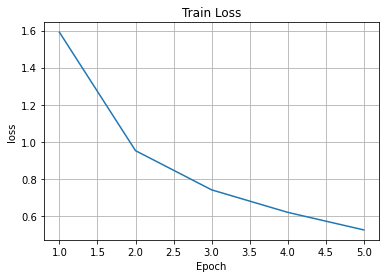

In [60]:
if new_model_train:
    optimizer = optim.Adam(model.parameters(), lr=LR)
    loss_history = Train(model, train_DL, criterion, optimizer, EPOCH)

    torch.save(model, save_model_path)

    plt.plot(range(1,EPOCH+1),loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.title("Train Loss")
    plt.grid()

In [61]:
load_model = torch.load(save_model_path, map_location=DEVICE)

In [62]:
Test(load_model, test_DL)
print(count_params(load_model))

Test accuracy: 7881/10000 (78.8 %)
1527018


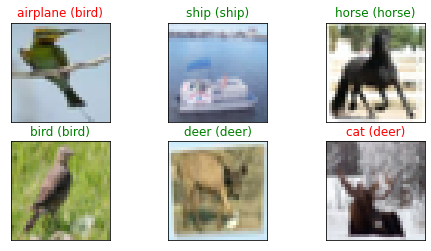

In [65]:
Test_plot(load_model, test_DL)